In [1]:
# TODO - device a strategy to check the gradients provided by each of the main components of the sim.
# TODO - suggest starting with RWA environment (5 nodes, 4 slots per link) with incremental loading
# TODO - it might be advisable to start a new test file that contains all the gradient checks.
# TODO - implement a template test to check the gradients of a function
# TODO - need to consider any possible edges cases e.g. allocation failure/success, fully masked slots, etc.
# TODO - need to first of all check the gradients returned by each of the main component functions:
# implement
# check
# undo
# finalise
# generate_request
# get_reward_failure
# get_reward_success
# get_action_mask
# reset
# step
# heuristics
# TODO - testing the larger components should reveal issue with subfunctions e.g. get paths, get path slots, etc.
# TODO - test that things still work when wrapped in a log env

In [1]:
import jax
import time
import optax
import jax.numpy as jnp
from absl import flags
from flax.training.train_state import TrainState
from gymnax.environments import environment
from scipy.signal.windows import general_hamming
from tensorflow_probability.substrates.jax.distributions.student_t import entropy

from xlron.environments.env_funcs import *
from xlron.environments.gn_model.isrs_gn_model import *
from xlron.environments.dataclasses import EnvState, EnvParams, VONETransition, RSATransition
from xlron.train.train_utils import *
import sys
from xlron.environments.make_env import *
from xlron import parameter_flags
from jax.test_util import check_grads

# We load the default flags
FLAGS = flags.FLAGS

list_of_requests = [
    [1.,1.,3.],
    [1.,1.,3.],
]
total_timesteps = len(list_of_requests)

# Then define our experiment...
env_config = {
    "env_type": "rwa",
    "k": 3,
    "link_resources": 4,
    "incremental_loading" : True,
    "end_first_blocking": False,
    "topology_name": "5node_undirected",
    "values_bw": [1],
    "slot_size": 1,
    "max_requests": total_timesteps,
    "temperature": 0.02,
    "deterministic_requests": True,
}

# ... and training details
train_config = {
    "SEED": 0,
    "NUM_LEARNERS": 1,
    "TOTAL_TIMESTEPS": total_timesteps,
    "NUM_ENVS": 1,
    "ROLLOUT_LENGTH": 3,
    "UPDATE_EPOCHS": 2,
    "LR": 5e-5,
    "GAMMA": 1.0, # For pre-training the VF, we don't use a discount factor
    "GAE_LAMBDA": 1.0, # For pre-training the VF, we don't use GAE
    "LR_SCHEDULE": "linear",
    "LAYER_NORM": True,
}

# We convert config to a Box container to make items accessible through both dict and dot notation
config = process_config(FLAGS, **env_config, **train_config)
config.list_of_requests = jnp.array(list_of_requests)


# INIT ENV
env, env_params = make(config, log_wrapper=False)
from gymnax.wrappers import GymnaxToGymWrapper
from xlron.models.models import ActorCriticMLP
gym_env = GymnaxToGymWrapper(env, env_params)
rng = jax.random.PRNGKey(config.SEED)
rng, key = jax.random.split(rng)
obsv, env_state = env.reset(key, env_params)
# Update env_state so that link_slot_array is only 0 in the first column
print(env_state.request_array)

# Cast everything to float32
env_state = jax.tree.map(lambda x: x.astype(jnp.float32), env_state)
action = env.action_space(env_params).sample(key)
action = action.astype(jnp.float32)

def set_link_slot_array(_state):
    _state = _state.replace(
        link_slot_array=_state.link_slot_array.at[:, 0].set(0.),
    )
    _state = _state.replace(
        link_slot_array=_state.link_slot_array.at[:, 1:].set(-1.),
    )
    _state = _state.replace(
        link_slot_departure_array=_state.link_slot_array.at[:, 0].set(0.),
    )
    _state = _state.replace(
        link_slot_departure_array=_state.link_slot_array.at[:, 1:].set(1e8),
    )
    # _state = _state.replace(
    #     request_array=jnp.array([1,1,3])
    # )
    _state = jax.tree.map(lambda x: x.astype(jnp.float32), _state)
    return _state
env_state = set_link_slot_array(env_state)
actions = jnp.array([3.5, 3.5]) # This should fail for both actions


# Define function to scan through actions and return the stacked states and rewards
runner_state = (key, env_state, env_params)
def env_step(_runner_state, _action):
    _key, _env_state, _env_params = _runner_state
    # Perform the step
    # _env_state = _env_state.replace(
    #     request_array=jnp.array([1,1,3])
    # # )
    jax.debug.print("requests: {}", _env_state.request_array)
    # jax.debug.print("link_slot_array: {}", _env_state.link_slot_array)
    # jax.debug.print("link_slot_departure_array: {}", _env_state.link_slot_departure_array)
    # jax.debug.print("ACTION: {}", _action, ordered=True) 
    #_action = differentiable_round_simple(_action, 0.1)#_env_params.temperature)
    # jax.debug.print("ACTION: {}", _action, ordered=True)
    obs, state, rewrd, done, info = env.step(_key, _env_state, _action, _env_params)
    jax.debug.print("link_slot_array: {}", state.link_slot_array)
    jax.debug.print("link_slot_departure_array: {}", state.link_slot_departure_array)
    return (_key, state, env_params), rewrd
def rollout(r_state, acs):
    _, st = env.reset(key, env_params)
    st = set_link_slot_array(r_state[1])
    r_state = (r_state[0], st, r_state[2])
    out, rew =  jax.lax.scan(env_step, r_state, acs)
    return out, rew

<class 'networkx.utils.decorators.argmap'> compilation 8:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


[1. 1. 3.]


/Users/michaeldoherty/Library/Caches/pypoetry/virtualenvs/xlron-QeH3eSKC-py3.11/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


In [ ]:
out_state, rewards = rollout(runner_state, actions)
print(out_state)
rewards.sum()

/Users/michaeldoherty/Library/Caches/pypoetry/virtualenvs/xlron-QeH3eSKC-py3.11/lib/python3.11/site-packages/jax/_src/core.py:700: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/Users/michaeldoherty/Library/Caches/pypoetry/virtualenvs/xlron-QeH3eSKC-py3.11/lib/python3.11/site-packages/jax/_src/core.py:700: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/Users/michaeldoherty/Library/Caches/pypoetry/virtualenvs/xlron-QeH3eSKC-py3.11/lib/python3.11/site-packages/jax/_src/core.py:700: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/Users/michaeldoherty/Library/Caches/pyp

In [4]:
import optax  # JAX's optimization library

def optimize_actions(env, env_state, env_params, initial_actions, n_iterations=100, learning_rate=0.01):
    """
    Optimize actions using gradient descent to maximize reward.
    
    Args:
        env: The environment
        env_state: Initial environment state
        env_params: Environment parameters
        initial_actions: Starting point for actions optimization
        n_iterations: Number of optimization steps
        learning_rate: Learning rate for gradient descent
    
    Returns:
        The optimized actions
    """
    # Initialize actions as trainable parameters
    actions = initial_actions
    
    # Create optimizer
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(actions)
    
    # Define differentiable loss function (negative total reward)
    @jax.jit
    def loss_fn(current_actions):
        e_state = env.reset(key, env_params)[1]
        e_state = set_link_slot_array(e_state)
        r_state = (jax.random.PRNGKey(0), e_state, env_params)  # Fixed seed for deterministic gradients
        _, rewrds = rollout(r_state, current_actions)
        return -jnp.sum(rewrds)  # Negative because we want to maximize reward
    
    # Define update step
    @jax.jit
    def update_step(actions, opt_state):
        loss_value, grads = jax.value_and_grad(loss_fn)(actions)
        
        # Add noise to gradients for exploration
        # noise = jax.random.normal(jax.random.PRNGKey(0), actions.shape) * 0.0001
        # grads += noise
        
        updates, new_opt_state = optimizer.update(grads, opt_state)
        new_actions = optax.apply_updates(actions, updates)
        
        # Optional: Project actions back to valid range if needed
        new_actions = jnp.clip(new_actions, 0, 11)
        
        return new_actions, new_opt_state, loss_value, grads, updates
    
    # Optimization loop
    losses = []
    for i in range(n_iterations):
        
        # # Add noise to actions during optimization
        nkey = jax.random.PRNGKey(i)  # Different seed each iteration
        noise_scale = max(0.01 * (1.0 - i/n_iterations), 0.01)  # Annealing noise
        noise = jax.random.normal(nkey, actions.shape) * noise_scale
        actions = actions + noise

        actions, opt_state, loss_value, grads, updates = update_step(actions, opt_state)
        losses.append(loss_value)
        if i % 1000 == 0:
            print(f"Iteration {i}, Loss: {loss_value}")
            jax.debug.print("new actions: {}", jnp.round(actions, 3))
            jax.debug.print("grads: {}", jnp.round(grads, 5))
            jax.debug.print("updates: {}", jnp.round(updates, 4))
    
    return actions, losses

# Get initial random actions
initial_actions = jnp.array([5.0, 5.0])
#initial_actions = jnp.full((10,), 2.0)  # Initialize with 3.0
print(f"intial actions: {initial_actions}")
# Tile intitial actions 10 times
initial_actions = jnp.tile(initial_actions, (1,))
print("total actions: ", initial_actions.shape)

env_state = set_link_slot_array(env_state)
jax.debug.print("initial requests: {}", env_state.request_array)

# Optimize actions
optimized_actions, loss_history = optimize_actions(
    env, env_state, env_params, initial_actions, n_iterations=20000, learning_rate=0.001
)

# Run the optimized actions to visualize
env_state = set_link_slot_array(env_state)
final_state, final_rewards = rollout((key, env_state, env_params), jnp.round(optimized_actions))
print(f"Total reward with optimized actions: {jnp.sum(final_rewards)}")
print(f"final actions: {jnp.round(optimized_actions)}")
print(f"final_rewards: {final_rewards}")

intial actions: [5. 5.]
total actions:  (2,)
initial requests: [1. 1. 3.]
Iteration 0, Loss: 2.0
new actions: [4.992     5.0080004]
grads: [0. 0.]
updates: [-0.0004 -0.0004]
Iteration 1000, Loss: 2.0
new actions: [4.7390003 5.3710003]
grads: [0. 0.]
updates: [-0.0004 -0.0004]
Iteration 2000, Loss: -0.0
new actions: [4.354 4.227]
grads: [0. 0.]
updates: [-0.0003 -0.0003]
Iteration 3000, Loss: -0.0
new actions: [4.102 3.713]
grads: [0. 0.]
updates: [-0.0003 -0.0003]
Iteration 4000, Loss: -0.0
new actions: [4.2440004 3.8360002]
grads: [0. 0.]
updates: [-0.0003 -0.0003]
Iteration 5000, Loss: -0.0
new actions: [3.8390002 3.6970003]
grads: [0. 0.]
updates: [-0.0003 -0.0003]
Iteration 6000, Loss: -0.0
new actions: [3.6890001 3.134    ]
grads: [ 0. -0.]
updates: [-0.0003  0.0004]
Iteration 7000, Loss: -0.0
new actions: [3.5110002 3.2740002]
grads: [ 0. -0.]
updates: [1.e-04 4.e-04]
Iteration 8000, Loss: 2.0
new actions: [3.44  3.403]
grads: [-0. -0.]
updates: [0.0002 0.0004]
Iteration 9000, Lo

In [5]:
# Check the gradients of step()
check_grads(lambda x: jnp.sum(rollout(runner_state, x)[1]).astype(jnp.float32), args=(actions,), order=1, rtol=1e-3, atol=1e-3)
jax.grad(lambda x: jnp.sum(rollout(runner_state, x)[1]).astype(jnp.float32))(actions)

requests: [1. 1. 3.]
num_slots [1.]
link_slot_array: [[ 0. -1. -1. -1.]
 [ 0. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [ 0. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [ 0. -1. -1. -1.]]
link_slot_departure_array: [[0.e+00 1.e+08 1.e+08 1.e+08]
 [0.e+00 1.e+08 1.e+08 1.e+08]
 [6.e+00 1.e+08 1.e+08 1.e+08]
 [0.e+00 1.e+08 1.e+08 1.e+08]
 [6.e+00 1.e+08 1.e+08 1.e+08]
 [0.e+00 1.e+08 1.e+08 1.e+08]]
requests: [1. 1. 3.]
num_slots [1.]
link_slot_array: [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
link_slot_departure_array: [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
requests: [1. 1. 3.]
num_slots [1.]
link_slot_array: [[ 0. -1. -1. -1.]
 [ 0. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [ 0. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [ 0. -1. -1. -1.]]
link_slot_departure_array: [[0.e+00 1.e+08 1.e+08 1.e+08]
 [0.e+00 1.e+08 1.e+08 1.e+08]
 [6.e+00 1.e+08 1.e+08 1.e+08]
 [0.e+00 1.e+08 1.e+08 1.e+08]
 [6.e+00 1.e+08 1.e+08 1.e+08]
 [0.e+

AssertionError: 
Not equal to tolerance rtol=0.001, atol=0.001
JVP tangent
Mismatched elements: 1 / 1 (100%)
Max absolute difference: 10000.
Max relative difference: 1.
 x: array(-9.182053e-09, dtype=float32)
 y: array(10000., dtype=float32)

In [6]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from matplotlib import cm

# INIT ENV (using your existing code)
env, env_params = make(config, log_wrapper=False)
from gymnax.wrappers import GymnaxToGymWrapper
from xlron.models.models import ActorCriticMLP
gym_env = GymnaxToGymWrapper(env, env_params)
rng = jax.random.PRNGKey(config.SEED)
rng, key = jax.random.split(rng)
obsv, env_state = env.reset(key, env_params)
env_state = set_link_slot_array(env_state)

# Define a function to get reward for a single action pair
def get_reward(action_pair):
    action = jnp.array(action_pair, dtype=jnp.float32)
    _, rewards = rollout(runner_state, action)
    return jnp.sum(rewards).astype(jnp.float32)

# Create a jitted version of the function and its gradient
reward_fn = jax.jit(get_reward)
grad_fn = jax.grad(get_reward)

# Create a grid of action values from 0 to 8 in steps of 0.5
action_vals = jnp.arange(0, 8.5, 0.1)
action_grid = jnp.meshgrid(action_vals, action_vals)
action_pairs = jnp.stack([action_grid[0].flatten(), action_grid[1].flatten()], axis=1)

# Vectorize the reward and gradient functions
v_reward_fn = jax.vmap(reward_fn)
v_grad_fn = jax.vmap(grad_fn)

<class 'networkx.utils.decorators.argmap'> compilation 8:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


In [ ]:

# Calculate rewards and gradients for all action pairs
rewards = v_reward_fn(action_pairs)
gradients = v_grad_fn(action_pairs)

# Reshape for plotting
rewards_grid = rewards.reshape(len(action_vals), len(action_vals))
grad_x_grid = gradients[:, 0].reshape(len(action_vals), len(action_vals))
grad_y_grid = gradients[:, 1].reshape(len(action_vals), len(action_vals))
grad_magnitude = jnp.sqrt(grad_x_grid**2 + grad_y_grid**2).reshape(len(action_vals), len(action_vals))

# Convert to numpy for plotting
rewards_np = np.array(rewards_grid)
grad_x_np = np.array(grad_x_grid)
grad_y_np = np.array(grad_y_grid)
grad_mag_np = np.array(grad_magnitude)
x_np = np.array(action_grid[0])
y_np = np.array(action_grid[1])

2025-03-14 13:10:04.772423: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_get_reward] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


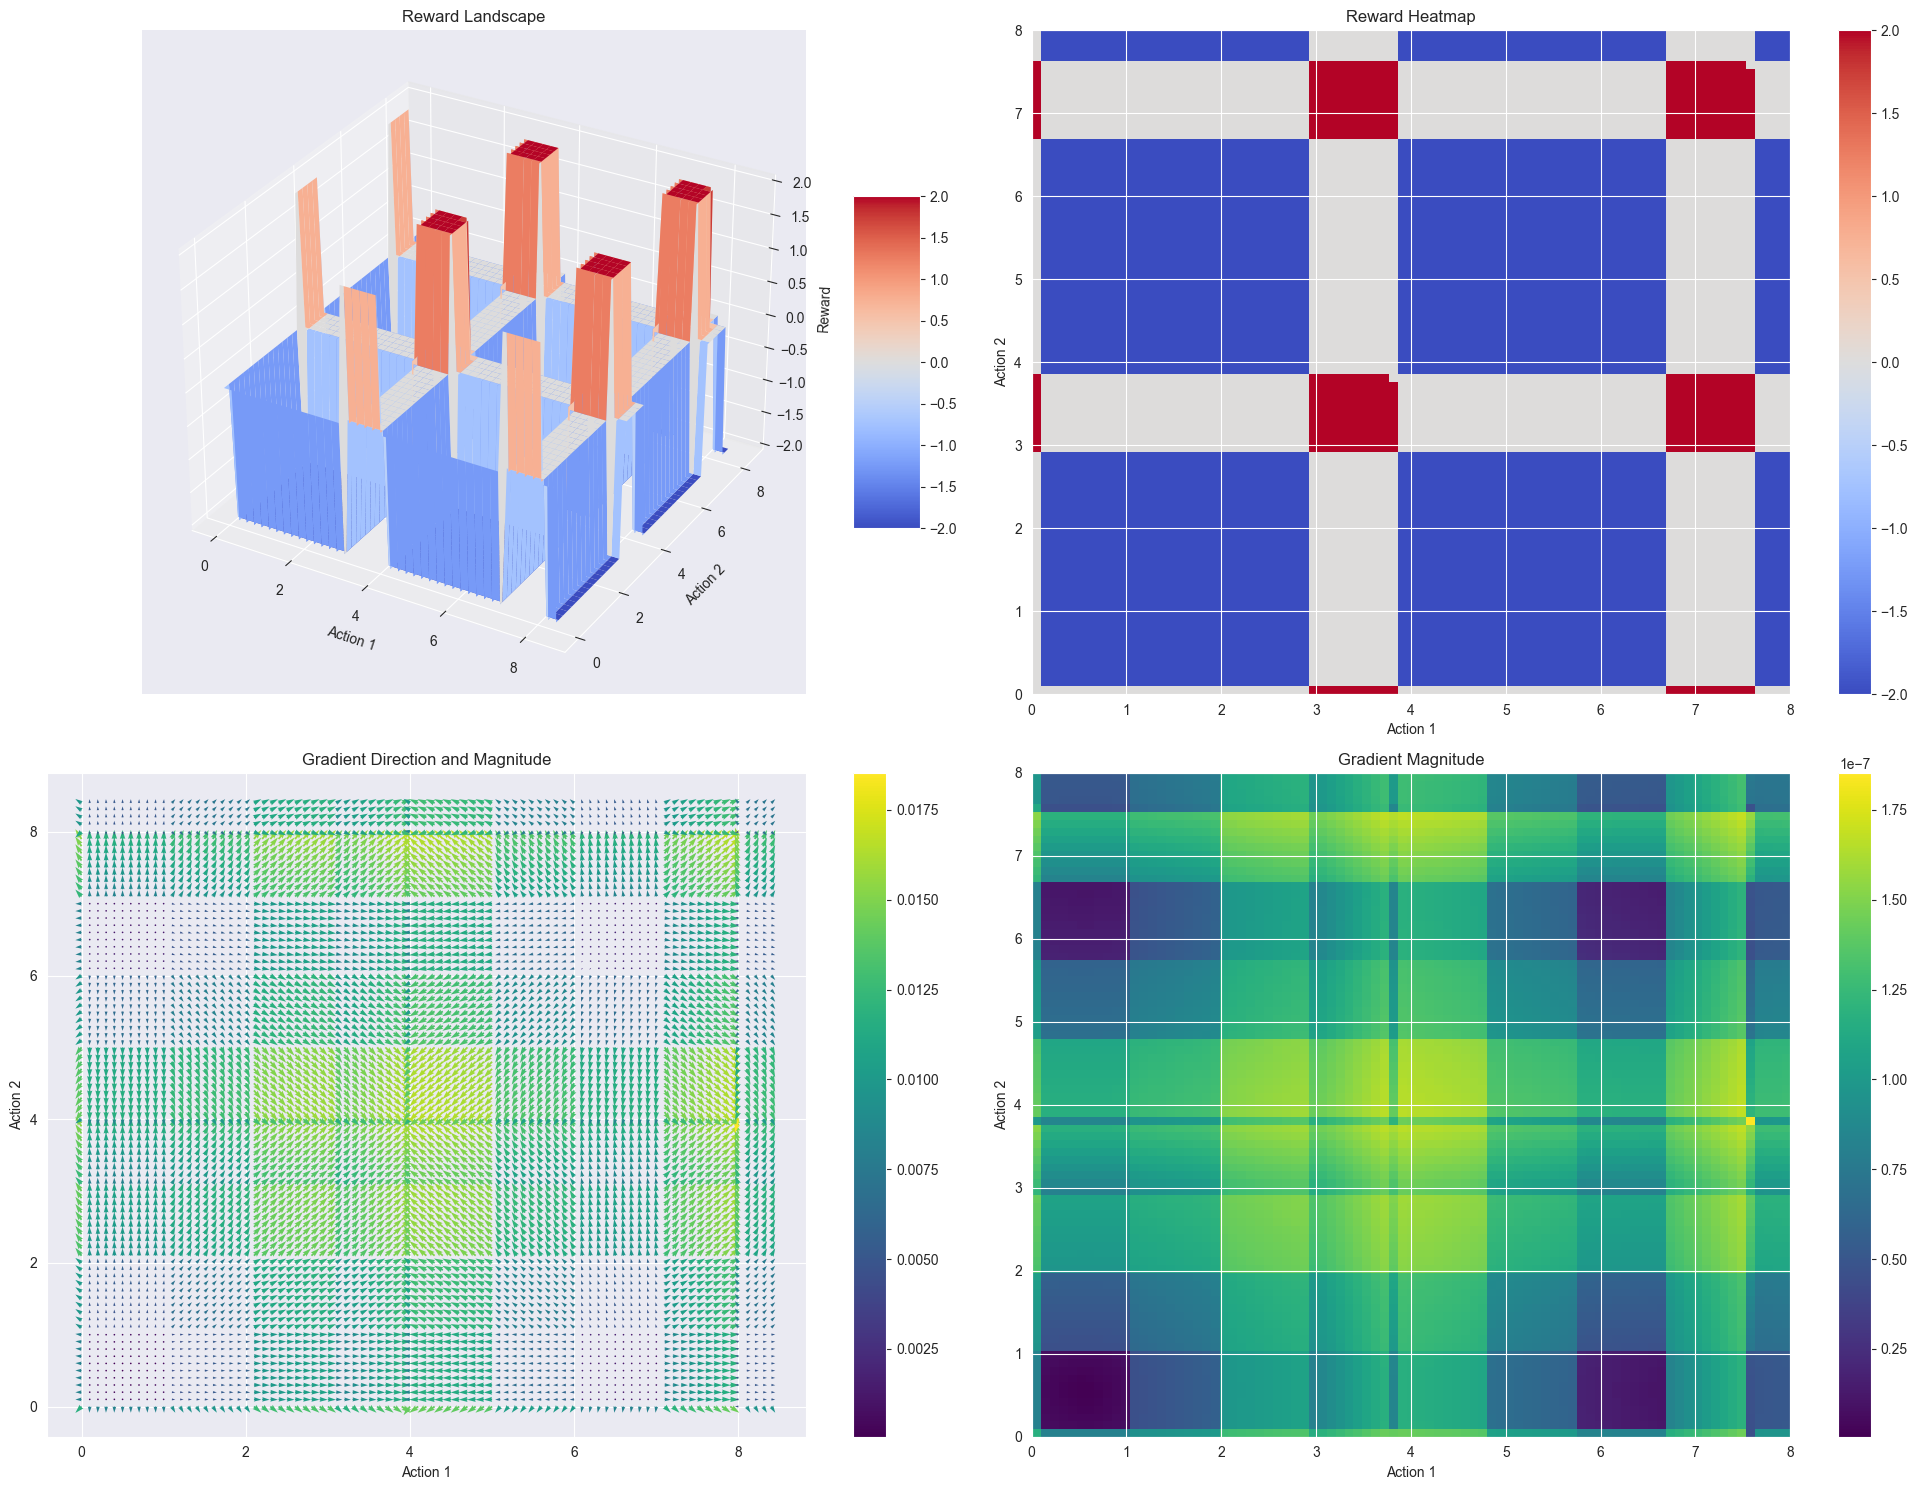

Maximum reward: 2.0
Maximum reward action pair: (Array(0., dtype=float32), Array(3.1000001, dtype=float32))
Minimum reward: -2.0
Minimum reward action pair: (Array(0.1, dtype=float32), Array(0.1, dtype=float32))
Maximum gradient magnitude: 1.8527167e-07
Maximum gradient action pair: (Array(4., dtype=float32), Array(8., dtype=float32))

Gradient values at selected points:
Action1 Action2  Reward  Grad_X  Grad_Y  Magnitude
-------------------------------------------------
   0.0    0.0    0.000  -0.000  -0.000     0.000
   0.0    0.1    0.000  -0.000  -0.000     0.000
   0.0    0.2    0.000  -0.000  -0.000     0.000
   0.0    0.3    0.000  -0.000  -0.000     0.000
   0.0    0.4    0.000  -0.000  -0.000     0.000
   0.0    0.5    0.000  -0.000  -0.000     0.000
   0.0    0.6    0.000   0.000  -0.000     0.000
   0.0    0.7    0.000   0.000  -0.000     0.000
   0.0    0.8    0.000   0.000  -0.000     0.000
   0.0    0.9    0.000   0.000  -0.000     0.000
   0.0    1.0    0.000   0.000  -0.

In [9]:
# Create a figure with multiple subplots
fig = plt.figure(figsize=(20, 15))

# 3D surface plot for rewards
ax1 = fig.add_subplot(2, 2, 1, projection='3d')
surf = ax1.plot_surface(x_np, y_np, rewards_np, cmap=cm.coolwarm, linewidth=0, antialiased=True)
ax1.set_xlabel('Action 1')
ax1.set_ylabel('Action 2')
ax1.set_zlabel('Reward')
ax1.set_title('Reward Landscape')
fig.colorbar(surf, ax=ax1, shrink=0.5, aspect=5)

# 2D heatmap for rewards
ax2 = fig.add_subplot(2, 2, 2)
im = ax2.imshow(rewards_np, origin='lower', extent=[0, 8, 0, 8], cmap='coolwarm', aspect='auto')
ax2.set_xlabel('Action 1')
ax2.set_ylabel('Action 2')
ax2.set_title('Reward Heatmap')
fig.colorbar(im, ax=ax2)

# Gradient quiver plot
ax3 = fig.add_subplot(2, 2, 3)
scale_array = lambda arr: arr * (0.1 / (10 ** np.floor(np.log10(np.max(np.abs(arr[arr != 0]))) + 1))) if np.any(arr != 0) else arr
quiv = ax3.quiver(x_np, y_np, scale_array(grad_x_np), scale_array(grad_y_np), scale_array(grad_mag_np), cmap='viridis', scale=1)
ax3.set_xlabel('Action 1')
ax3.set_ylabel('Action 2')
ax3.set_title('Gradient Direction and Magnitude')
fig.colorbar(quiv, ax=ax3)

# Gradient magnitude heatmap
ax4 = fig.add_subplot(2, 2, 4)
im2 = ax4.imshow(grad_mag_np, origin='lower', extent=[0, 8, 0, 8], cmap='viridis', aspect='auto')
ax4.set_xlabel('Action 1')
ax4.set_ylabel('Action 2')
ax4.set_title('Gradient Magnitude')
fig.colorbar(im2, ax=ax4)

plt.tight_layout()
plt.savefig('gradient_landscape.png', dpi=300)
plt.show()

# Print out some interesting points
# Print out some interesting points
print("Maximum reward:", np.max(rewards_np))
max_idx = np.unravel_index(np.argmax(rewards_np), rewards_np.shape)
print("Maximum reward action pair:", (action_vals[max_idx[0]], action_vals[max_idx[1]]))
print("Minimum reward:", np.min(rewards_np))
min_idx = np.unravel_index(np.argmin(rewards_np), rewards_np.shape)
print("Minimum reward action pair:", (action_vals[min_idx[0]], action_vals[min_idx[1]]))
print("Maximum gradient magnitude:", np.max(grad_mag_np))
max_grad_idx = np.unravel_index(np.argmax(grad_mag_np), grad_mag_np.shape)
print("Maximum gradient action pair:", (action_vals[max_grad_idx[0]], action_vals[max_grad_idx[1]]))

# Output a table of selected gradient values for verification
print("\nGradient values at selected points:")
print("Action1 Action2  Reward  Grad_X  Grad_Y  Magnitude")
print("-------------------------------------------------")
for a1 in list(action_vals):
    for a2 in list(action_vals):
        idx1 = np.where(action_vals == a1)[0][0]
        idx2 = np.where(action_vals == a2)[0][0]
        r = rewards_np[idx1, idx2]
        gx = grad_x_np[idx1, idx2]
        gy = grad_y_np[idx1, idx2]
        mag = grad_mag_np[idx1, idx2]
        print(f"{a1:6.1f} {a2:6.1f} {r:8.3f} {gx:7.3f} {gy:7.3f} {mag:9.3f}")

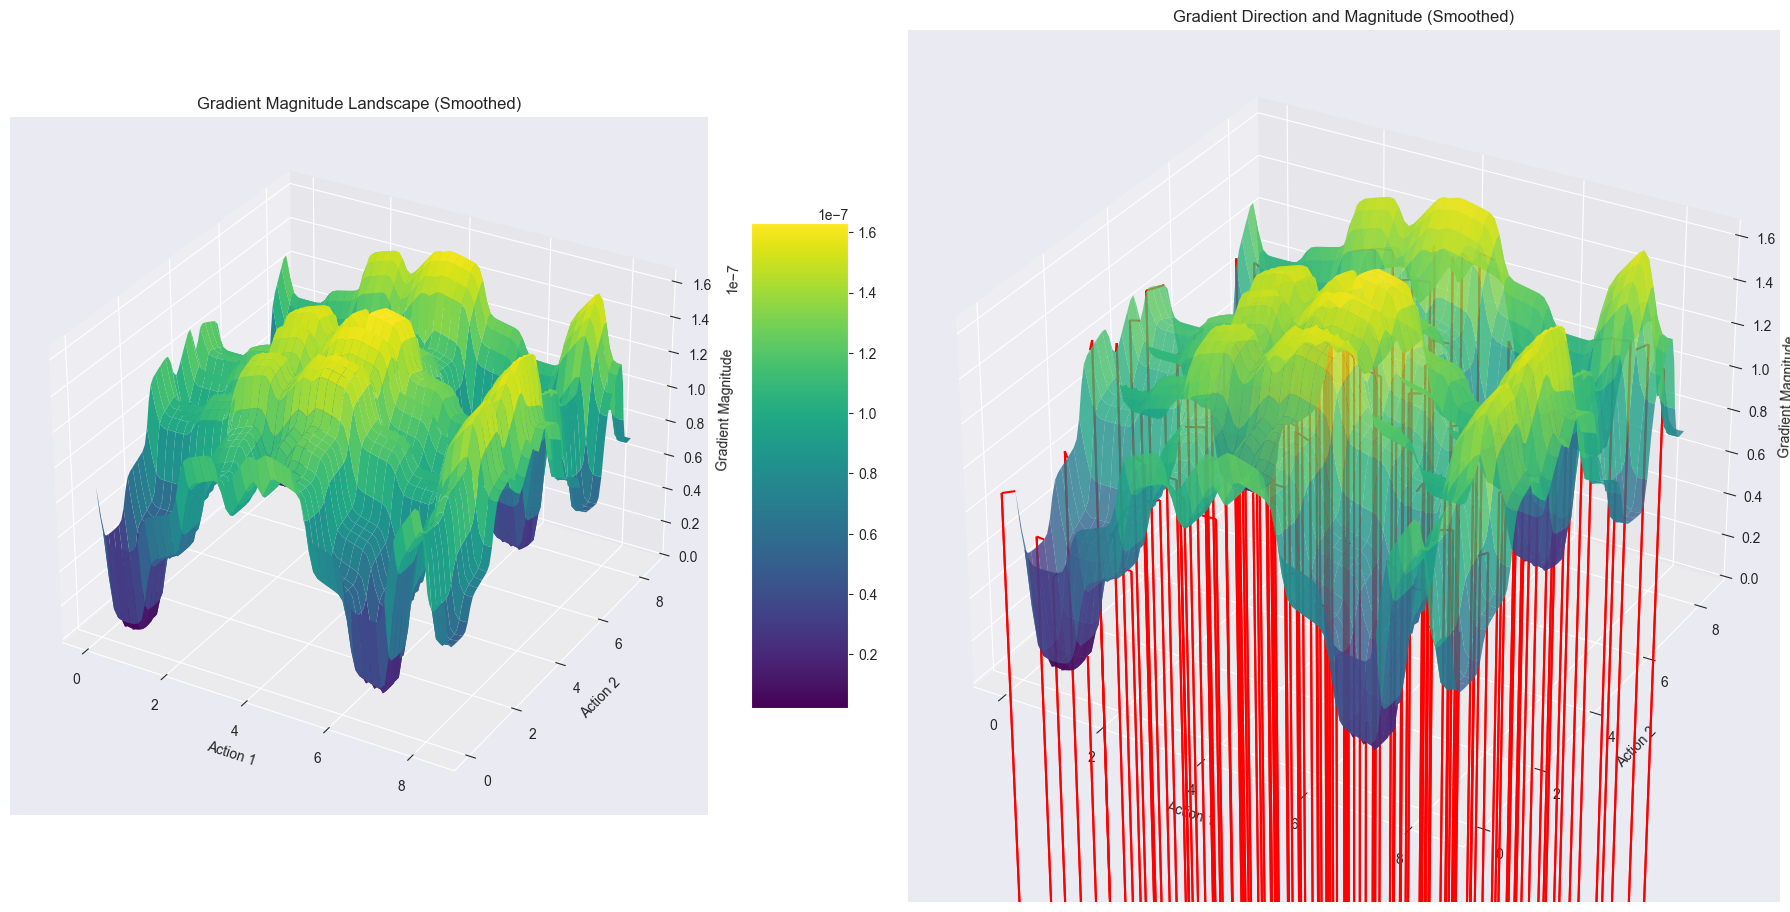

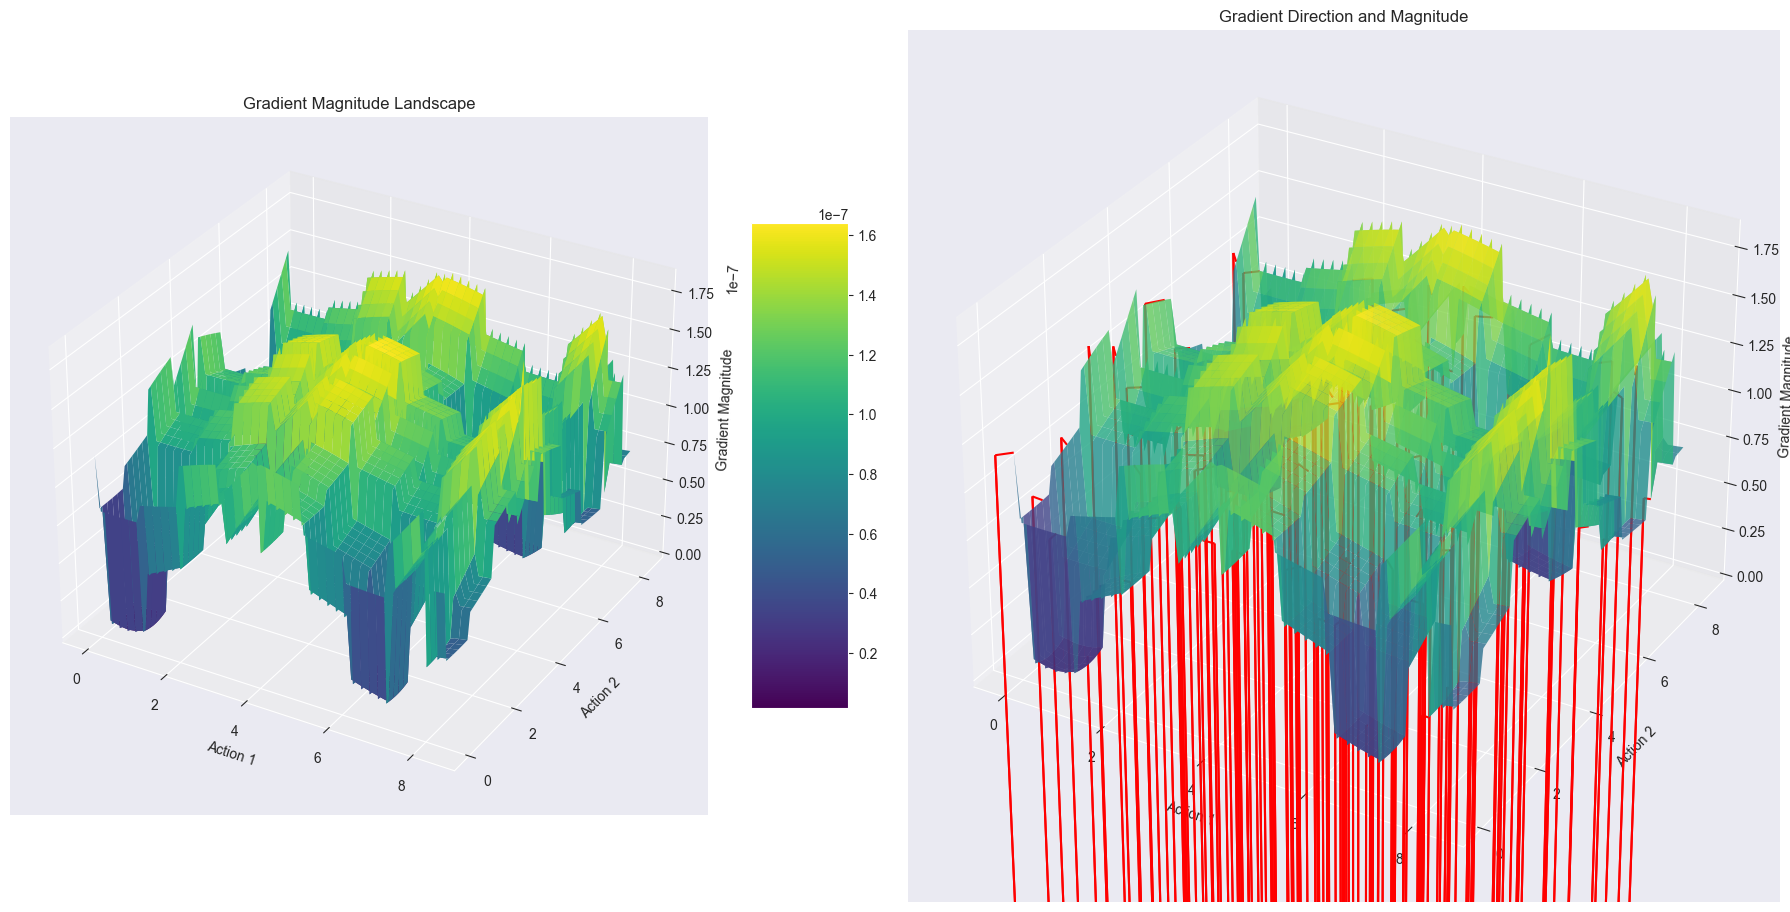

In [10]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.ndimage import gaussian_filter

def plot_gradient_landscape(action_vals, grad_x_np, grad_y_np, grad_mag_np, x_np, y_np, smooth=True, sigma=1.0):
    """
    Plot the gradient landscape in 3D, with options for smoothing.
    
    Args:
        action_vals: Array of action values used for the grid
        grad_x_np: X-component of gradients
        grad_y_np: Y-component of gradients
        grad_mag_np: Magnitude of gradients
        x_np: Grid of x-coordinates
        y_np: Grid of y-coordinates
        smooth: Whether to apply smoothing
        sigma: Smoothing parameter for gaussian filter
    """
    # Create a new figure for gradient landscape
    fig = plt.figure(figsize=(18, 10))
    
    # Apply smoothing if requested
    if smooth:
        grad_mag_smooth = gaussian_filter(grad_mag_np, sigma=sigma)
        grad_x_smooth = gaussian_filter(grad_x_np, sigma=sigma)
        grad_y_smooth = gaussian_filter(grad_y_np, sigma=sigma)
    else:
        grad_mag_smooth = grad_mag_np
        grad_x_smooth = grad_x_np
        grad_y_smooth = grad_y_np
    
    # 3D surface plot of gradient magnitude
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    surf = ax1.plot_surface(x_np, y_np, grad_mag_smooth, cmap=cm.viridis, 
                            linewidth=0, antialiased=True)
    ax1.set_xlabel('Action 1')
    ax1.set_ylabel('Action 2')
    ax1.set_zlabel('Gradient Magnitude')
    ax1.set_title('Gradient Magnitude Landscape' + (' (Smoothed)' if smooth else ''))
    fig.colorbar(surf, ax=ax1, shrink=0.5, aspect=5)
    
    # 3D surface with gradient direction arrows
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    surf2 = ax2.plot_surface(x_np, y_np, grad_mag_smooth, cmap=cm.viridis, 
                             alpha=0.8, linewidth=0, antialiased=True)

    # Add arrows to show gradient direction in 3D
    # We'll sample fewer points for clarity
    stride = len(action_vals) // 10
    if stride < 1: stride = 1
    
    # Scale arrows appropriately
    max_grad = np.max(np.sqrt(grad_x_smooth**2 + grad_y_smooth**2))
    arrow_scale = 0.5 / max_grad if max_grad > 0 else 1.0
    
    for i in range(0, len(action_vals), stride):
        for j in range(0, len(action_vals), stride):
            ax2.quiver(x_np[i, j], y_np[i, j], grad_mag_smooth[i, j],
                      grad_x_smooth[i, j] * arrow_scale,
                      grad_y_smooth[i, j] * arrow_scale,
                      0,  # No z-component for gradient
                      color='r', arrow_length_ratio=0.3)
    
    ax2.set_xlabel('Action 1')
    ax2.set_ylabel('Action 2')
    ax2.set_zlabel('Gradient Magnitude')
    ax2.set_title('Gradient Direction and Magnitude' + (' (Smoothed)' if smooth else ''))
    
    plt.tight_layout()
    plt.savefig('gradient_landscape_3d.png', dpi=300)
    plt.show()

# Use the function with your existing data
plot_gradient_landscape(action_vals, grad_x_np, grad_y_np, grad_mag_np, x_np, y_np, smooth=True, sigma=1.0)

# Also plot unsmoothed version for comparison
plot_gradient_landscape(action_vals, grad_x_np, grad_y_np, grad_mag_np, x_np, y_np, smooth=False)

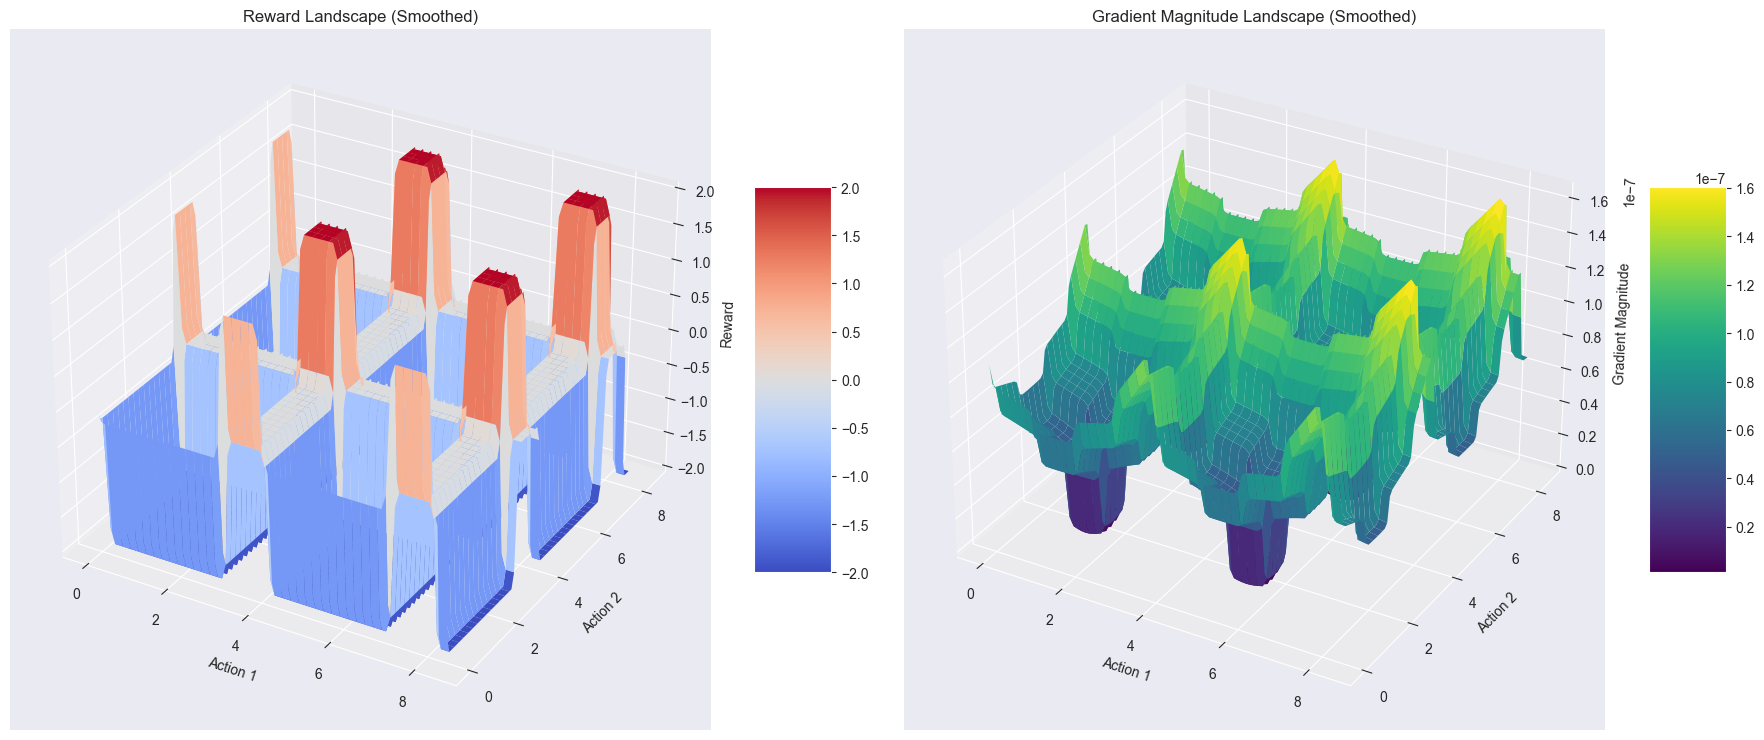

In [18]:
def compare_reward_and_gradient(action_vals, rewards_np, grad_mag_np, x_np, y_np, smooth=True, sigma=0.5):
    """Compare reward landscape with gradient landscape side-by-side in 3D"""
    fig = plt.figure(figsize=(18, 8))
    
    # Reward landscape
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    if smooth:
        rewards_smooth = gaussian_filter(rewards_np, sigma=sigma)
    else:
        rewards_smooth = rewards_np
    
    surf1 = ax1.plot_surface(x_np, y_np, rewards_smooth, cmap=cm.coolwarm, 
                            linewidth=0, antialiased=True)
    ax1.set_xlabel('Action 1')
    ax1.set_ylabel('Action 2')
    ax1.set_zlabel('Reward')
    ax1.set_title('Reward Landscape' + (' (Smoothed)' if smooth else ''))
    fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)
    
    # Gradient landscape
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    if smooth:
        grad_mag_smooth = gaussian_filter(grad_mag_np, sigma=sigma)
    else:
        grad_mag_smooth = grad_mag_np
        
    surf2 = ax2.plot_surface(x_np, y_np, grad_mag_smooth, cmap=cm.viridis, 
                            linewidth=0, antialiased=True)
    ax2.set_xlabel('Action 1')
    ax2.set_ylabel('Action 2')
    ax2.set_zlabel('Gradient Magnitude')
    ax2.set_title('Gradient Magnitude Landscape' + (' (Smoothed)' if smooth else ''))
    fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)
    
    plt.tight_layout()
    plt.savefig('reward_vs_gradient.png', dpi=300)
    plt.show()

# Compare smoothed landscapes
compare_reward_and_gradient(action_vals, rewards_np, grad_mag_np, x_np, y_np, smooth=True)

<class 'networkx.utils.decorators.argmap'> compilation 8:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


Analyzing dependency of action 2 on action 1...
Analyzing dependency of action 1 on action 2...
Calculating Jacobians at specific points...


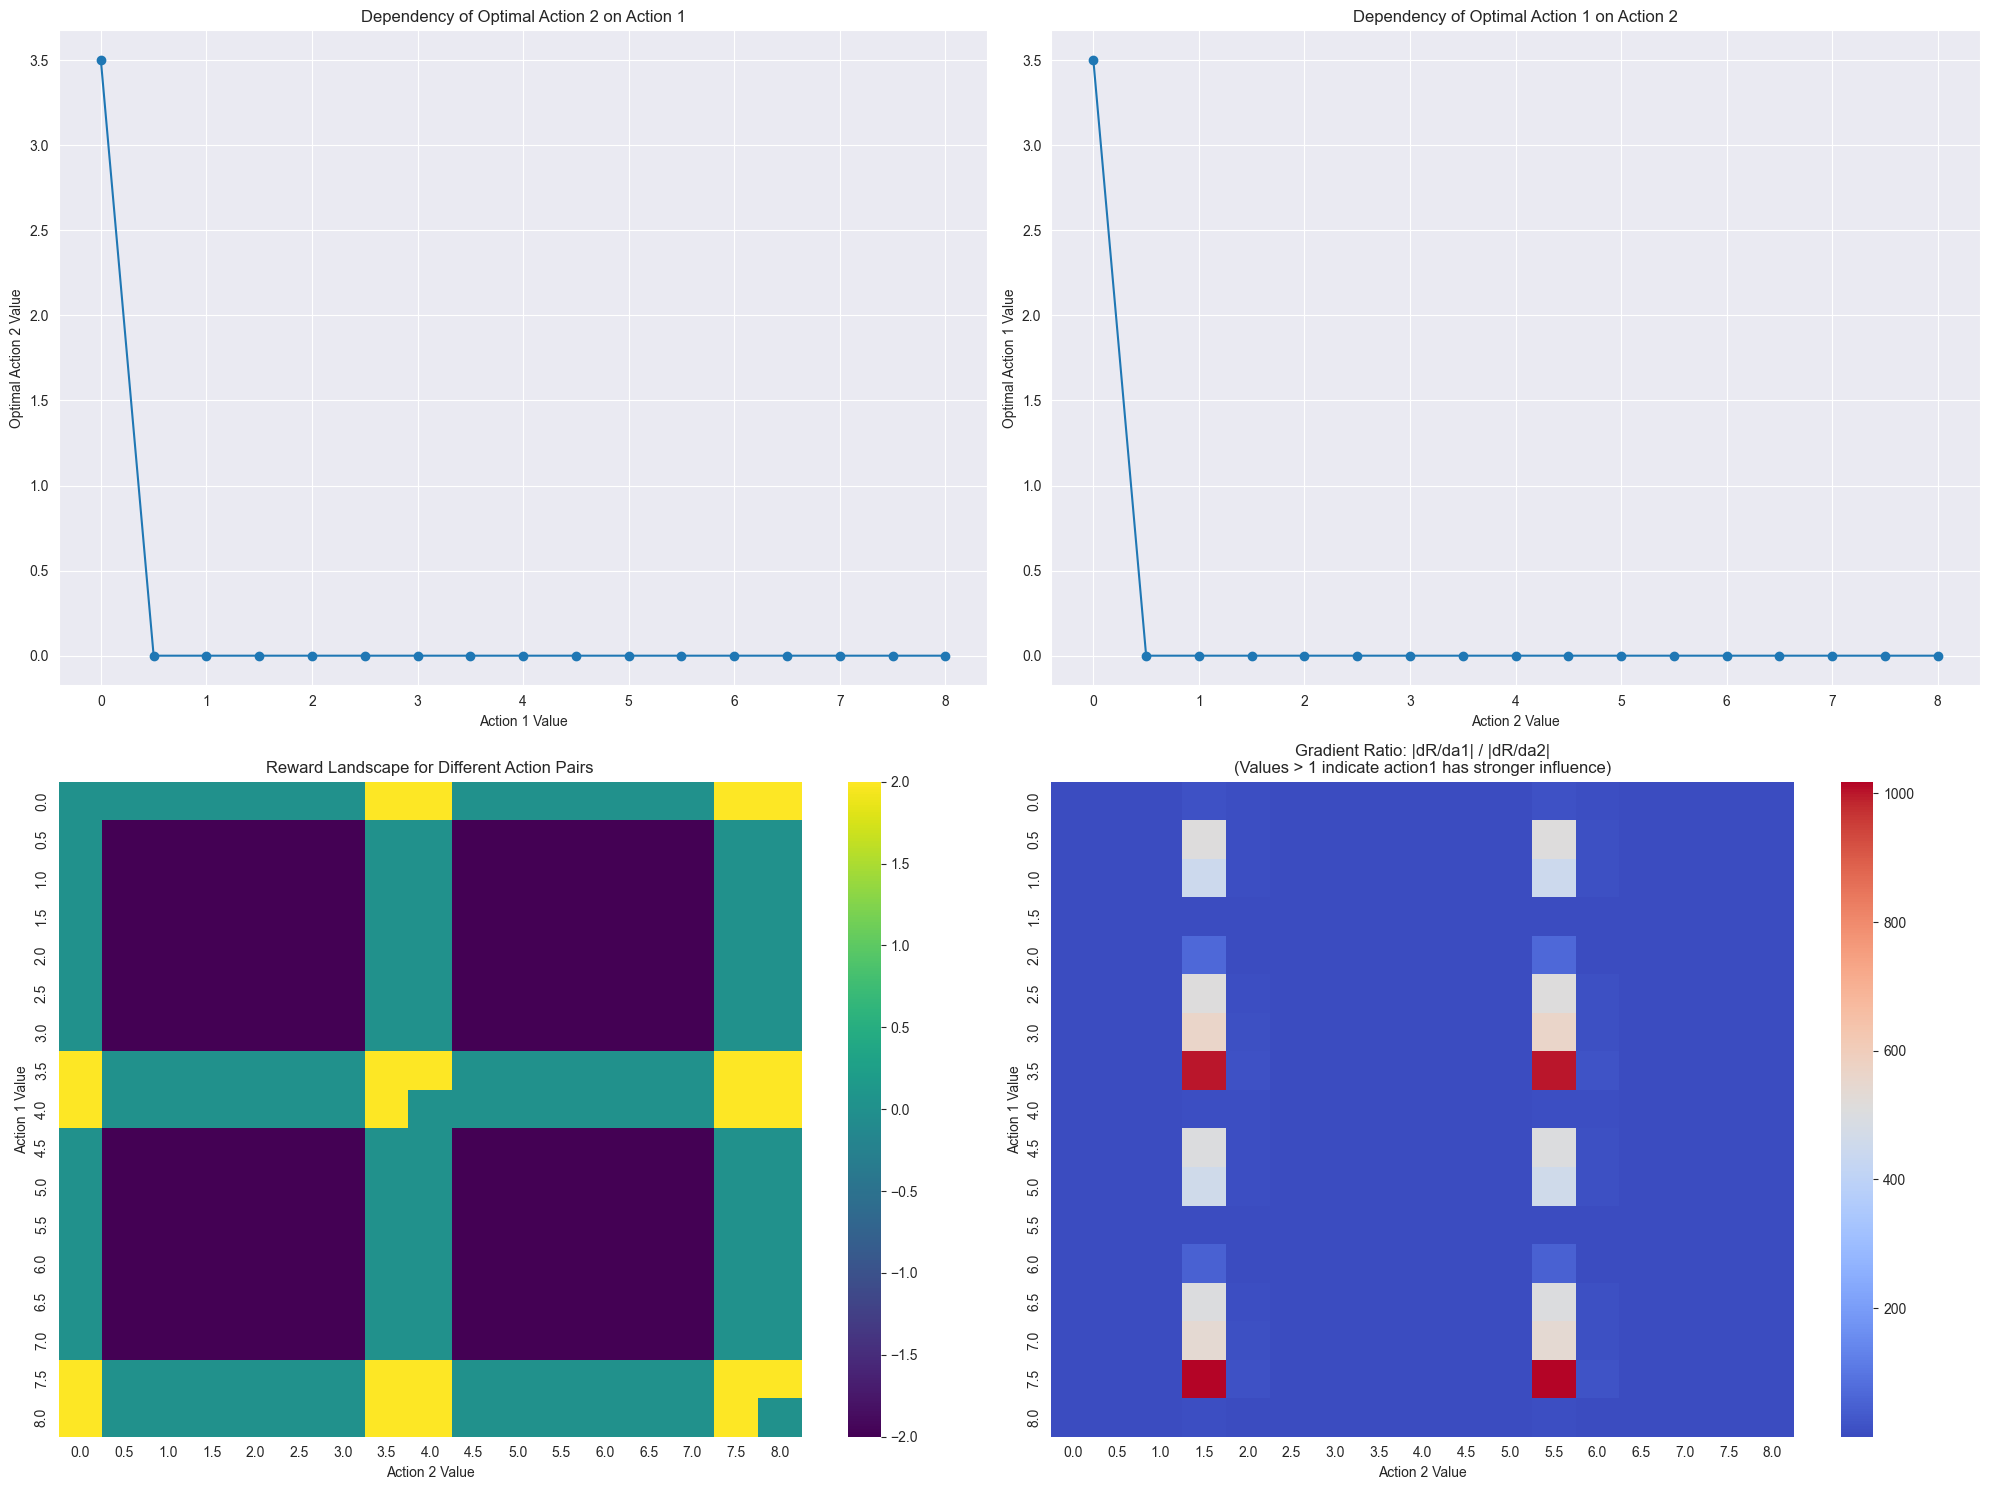


Jacobian Analysis Results:
-------------------------
action1 action2  dR/da1     dR/da2     gradient_ratio
0.0     0.0     -0.0000    -0.0000    1.0009     
0.0     0.5     -0.0000    -0.0000    1.6425     
0.0     1.0     -0.0000    -0.0000    1.9553     
0.0     1.5     -0.0000    0.0000     12.7022    
0.0     2.0     -0.0000    0.0000     5.5602     
0.0     2.5     -0.0000    0.0000     1.3148     
0.0     3.0     -0.0000    0.0000     1.1913     
0.0     3.5     -0.0000    0.0000     0.7073     
0.0     4.0     -0.0000    -0.0000    0.9481     
0.0     4.5     -0.0000    -0.0000    1.6514     
0.0     5.0     -0.0000    -0.0000    1.8844     
0.0     5.5     -0.0000    0.0000     14.4296    
0.0     6.0     -0.0000    0.0000     6.7509     
0.0     6.5     -0.0000    0.0000     1.3530     
0.0     7.0     -0.0000    0.0000     1.2557     
0.0     7.5     -0.0000    0.0000     0.7028     
0.0     8.0     -0.0000    -0.0000    0.9156     
0.5     0.0     -0.0000    -0.0000    0.65

In [15]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

# INIT ENV (using your existing code)
env, env_params = make(config, log_wrapper=False)
from gymnax.wrappers import GymnaxToGymWrapper
gym_env = GymnaxToGymWrapper(env, env_params)
rng = jax.random.PRNGKey(config.SEED)
rng, key = jax.random.split(rng)
obsv, env_state = env.reset(key, env_params)
env_state = set_link_slot_array(env_state)
env_state = jax.tree.map(lambda x: x.astype(jnp.float32), env_state)

# Initial runner state
runner_state = (key, env_state, env_params)

# Define reward function for a pair of actions
def reward_fn(actions):
    # Extract the scalar actions from the input array
    # The environment expects scalar actions, not vectors
    action1 = actions[0]  
    action2 = actions[1]
    
    # Create a sequence of scalar actions
    actions_sequence = jnp.array([action1, action2])
    
    _, rewards = rollout(runner_state, actions_sequence)
    return jnp.sum(rewards).astype(jnp.float32)

# Define Jacobian calculation
def jacobian_fn(actions):
    return jax.jacfwd(reward_fn)(actions)

# Jit the functions for performance
jit_reward_fn = jax.jit(reward_fn)
jit_grad_fn = jax.jit(jax.grad(reward_fn))
jit_jacobian_fn = jax.jit(jacobian_fn)

# Create a grid of action values
action_vals = np.arange(0, 8.5, 0.5)

# First, let's analyze the dependency of action 2's optimal value on action 1
# For each action 1 value, find the optimal action 2 value
optimal_action2 = np.zeros_like(action_vals)
rewards_for_fixed_action1 = np.zeros((len(action_vals), len(action_vals)))

print("Analyzing dependency of action 2 on action 1...")
for i, a1 in enumerate(action_vals):
    rewards_for_a1 = []
    for j, a2 in enumerate(action_vals):
        # Create an array with just the two scalar actions
        actions = jnp.array([a1, a2], dtype=jnp.float32)
        reward = jit_reward_fn(actions)
        rewards_for_a1.append(float(reward))
        rewards_for_fixed_action1[i, j] = float(reward)
    
    # Find the action 2 value that maximizes reward for this action 1
    optimal_action2[i] = action_vals[np.argmax(rewards_for_a1)]

# Now, let's do the reverse - find optimal action 1 for each action 2
optimal_action1 = np.zeros_like(action_vals)
rewards_for_fixed_action2 = np.zeros((len(action_vals), len(action_vals)))

print("Analyzing dependency of action 1 on action 2...")
for j, a2 in enumerate(action_vals):
    rewards_for_a2 = []
    for i, a1 in enumerate(action_vals):
        # Create an array with just the two scalar actions
        actions = jnp.array([a1, a2], dtype=jnp.float32)
        reward = jit_reward_fn(actions)
        rewards_for_a2.append(float(reward))
        rewards_for_fixed_action2[j, i] = float(reward)
    
    # Find the action 1 value that maximizes reward for this action 2
    optimal_action1[j] = action_vals[np.argmax(rewards_for_a2)]

# Now, let's calculate the Jacobian (cross-derivatives) at specific points
print("Calculating Jacobians at specific points...")
jacobian_results = []
for a1 in action_vals:
    for a2 in action_vals:
        actions = jnp.array([a1, a2], dtype=jnp.float32)
        # Compute Jacobian at this point
        jac = jit_jacobian_fn(actions)
        # Store results
        jacobian_results.append({
            'action1': a1,
            'action2': a2,
            'dR/da1': float(jac[0]),  # Effect of changing action1
            'dR/da2': float(jac[1]),  # Effect of changing action2
        })

# Create visualization
fig = plt.figure(figsize=(20, 15))

# Plot optimal action 2 for each action 1 value
ax1 = fig.add_subplot(2, 2, 1)
ax1.plot(action_vals, optimal_action2, 'o-')
ax1.set_xlabel('Action 1 Value')
ax1.set_ylabel('Optimal Action 2 Value')
ax1.set_title('Dependency of Optimal Action 2 on Action 1')
ax1.grid(True)

# Plot optimal action 1 for each action 2 value
ax2 = fig.add_subplot(2, 2, 2)
ax2.plot(action_vals, optimal_action1, 'o-')
ax2.set_xlabel('Action 2 Value')
ax2.set_ylabel('Optimal Action 1 Value')
ax2.set_title('Dependency of Optimal Action 1 on Action 2')
ax2.grid(True)

# Plot heatmap of rewards for fixed action 1
ax3 = fig.add_subplot(2, 2, 3)
sns.heatmap(rewards_for_fixed_action1, ax=ax3, cmap='viridis',
            xticklabels=action_vals.round(1), yticklabels=action_vals.round(1))
ax3.set_xlabel('Action 2 Value')
ax3.set_ylabel('Action 1 Value')
ax3.set_title('Reward Landscape for Different Action Pairs')

# Create a detailed visualization of the Jacobian results
ax4 = fig.add_subplot(2, 2, 4)
jacobian_df = pd.DataFrame(jacobian_results)

# Calculate the ratio of derivatives to assess interdependency
jacobian_df['grad_ratio'] = np.abs(jacobian_df['dR/da1'] / (jacobian_df['dR/da2'] + 1e-10))

# Plot the gradient ratio as an indicator of relative importance
grad_ratio_data = jacobian_df.pivot(index='action1', columns='action2', values='grad_ratio')
sns.heatmap(grad_ratio_data, ax=ax4, cmap='coolwarm', 
            xticklabels=grad_ratio_data.columns.round(1), 
            yticklabels=grad_ratio_data.index.round(1))
ax4.set_xlabel('Action 2 Value')
ax4.set_ylabel('Action 1 Value')
ax4.set_title('Gradient Ratio: |dR/da1| / |dR/da2|\n(Values > 1 indicate action1 has stronger influence)')

plt.tight_layout()
plt.savefig('action_dependency_analysis.png', dpi=300)
plt.show()

# Print out detailed Jacobian results for inspection
print("\nJacobian Analysis Results:")
print("-------------------------")
print("action1 action2  dR/da1     dR/da2     gradient_ratio")
for result in jacobian_results:
    print(f"{result['action1']:<7.1f} {result['action2']:<7.1f} "
          f"{result['dR/da1']:<10.4f} {result['dR/da2']:<10.4f} "
          f"{np.abs(result['dR/da1'] / (result['dR/da2'] + 1e-10)):<11.4f}")

# Add some diagnostic calculations to check state dependence
print("\nChecking for state dependence between action1 and action2:")
print("--------------------------------------------------------")

# Let's check how different action1 values change the environment state
# For simplicity, let's use a few values of action1

for a1 in action_vals:
    # Create action in the format the environment expects (scalar value)
    action1 = jnp.array(a1, dtype=jnp.float32)
    
    # Run the first action and get the resulting state
    (_, state_after_a1, _), _ = env_step((key, env_state, env_params), action1)
    
    # Now try different action2 values on this state
    rewards_after_a1 = []
    for a2 in action_vals:
        # Create action2 in the format the environment expects
        action2 = jnp.array(a2, dtype=jnp.float32)
        
        # Run action2 from the state after action1
        (_, _, _), reward_a2 = env_step((key, state_after_a1, env_params), action2)
        rewards_after_a1.append(float(reward_a2))
    
    # Print the rewards for different action2 values after this action1
    print(f"Action1={a1}: Rewards for Action2 values [0.0, 2.0, 4.0, 6.0, 8.0]: {rewards_after_a1}")
    
    # Find the best action2 after this action1
    best_a2_idx = np.argmax(rewards_after_a1)
    best_a2 = list(action_vals)[best_a2_idx]
    print(f"  Best Action2 after Action1={a1} is {best_a2} with reward {rewards_after_a1[best_a2_idx]}")

In [28]:
# Check the gradients of step()
#check_grads(lambda x: jnp.sum(env.step(key, env_state, x, env_params)[2]).astype(jnp.float32), args=(action,), order=1, rtol=1e-3, atol=1e-3)
jax.grad(lambda x: jnp.sum(env.step(key, env_state, x, env_params)[2]).astype(jnp.float32))(action)

Array(-8.418829e-08, dtype=float32)

intial actions: [1.  3.  6.5]
total actions:  (3,)
initial requests: [2. 1. 3.]
Iteration 0, Loss: 3.0
new actions: [1.0170001 2.996     6.504    ]
grads: [ 0. -0. -0.]
updates: [-0.0007  0.001   0.001 ]
Iteration 1000, Loss: -1.0
new actions: [0.39000002 3.7270002  7.728     ]
grads: [ 0. -0. -0.]
updates: [-0.001   0.0011  0.0012]
Iteration 2000, Loss: 3.0
new actions: [0.038     4.0620003 8.08     ]
grads: [0. 0. 0.]
updates: [-0.0009 -0.0005 -0.0006]
Iteration 3000, Loss: 1.0
new actions: [0.135     3.9620001 8.134001 ]
grads: [ 0. -0.  0.]
updates: [-0.0008  0.0015 -0.0006]
Iteration 4000, Loss: -1.0
new actions: [0.12400001 3.9740002  7.991     ]
grads: [ 0. -0. -0.]
updates: [-0.0009  0.0012  0.0009]
Iteration 5000, Loss: 3.0
new actions: [0.086 4.058 8.145]
grads: [0. 0. 0.]
updates: [-0.0004 -0.0005 -0.0008]
Iteration 6000, Loss: -1.0
new actions: [0.        3.9600003 8.119    ]
grads: [-0. -0.  0.]
updates: [-0.0003  0.0013 -0.0007]
Iteration 7000, Loss: 3.0
new actions: [0.1

In [8]:
import jax
from jax.core import eval_jaxpr
from jax import make_jaxpr

# Define your function (simplified version of what you have)
def func(env_state, action):
    return jnp.sum(env.step(key, env_state, action, env_params)[2]).astype(jnp.float32)

# Get the JAX expression representation
jaxpr = make_jaxpr(func)(env_state, action)

# Print the JAXpr to see primitives
print(jaxpr)

# Modern approach to debug JAX internals
def debug_primals(f, *args):
    # Get the jaxpr
    jaxpr = jax.make_jaxpr(f)(*args)
    print(f"JAXpr: {jaxpr}")
    
    # For more detailed debugging, use these utilities
    from jax._src import linear_util as lu
    from jax.interpreters import partial_eval as pe
    
    # Trace the function to get primals, etc.
    #fun = lu.wrap_init(f)
    primals_trace, tangents_trace = jax.linearize(f, *args)
    print(f"Primals trace: {primals_trace}")
    
    # For even more detailed debugging
    with jax.disable_jit():
        result = f(*args)
        print(f"Result with JIT disabled: {result}")
    
    return result

# Use this instead of your check_grads call
result = debug_primals(func, env_state, action)

let _where = { lambda ; a:bool[] b:f32[1] c:f32[1]. let
    d:f32[1] = select_n a c b
  in (d,) } in
let _where1 = { lambda ; e:bool[] f:i32[] g:f32[]. let
    h:f32[] = convert_element_type[new_dtype=float32 weak_type=False] f
    i:f32[] = select_n e g h
  in (i,) } in
let _where2 = { lambda ; j:bool[] k:f32[5,5] l:f32[5,5]. let
    m:f32[5,5] = select_n j l k
  in (m,) } in
let _where3 = { lambda ; n:bool[] o:i32[12] p:f32[12]. let
    q:f32[12] = convert_element_type[new_dtype=float32 weak_type=False] o
    r:f32[12] = select_n n p q
  in (r,) } in
let _where4 = { lambda ; s:bool[] t:i32[1] u:f32[1]. let
    v:f32[1] = convert_element_type[new_dtype=float32 weak_type=False] t
    w:f32[1] = select_n s u v
  in (w,) } in
let _where5 = { lambda ; x:bool[] y:f32[12] z:f32[12]. let
    ba:f32[12] = select_n x z y
  in (ba,) } in
let _where6 = { lambda ; bb:bool[] bc:f32[] bd:f32[]. let
    be:f32[] = convert_element_type[new_dtype=float32 weak_type=False] bc
    bf:f32[] = select_n bb 

In [7]:
def test_differentiable_indexing():
    array = jnp.arange(10.0)  # Smaller array for clarity
    indices = jnp.array([2.0, 3.0])
    indices = jnp.array([1.,4.])
    
    # Add temperature as a parameter to test different values
    def index_fn(array, indices, temperature=1.0):
        return differentiable_indexing(array, indices, window_size=5, temperature=temperature).sum() ** 2 
    
    # Test with different temperature values
    temperatures = [0.0001, 0.01, 0.1, 1.0, 10.0, 100.0]
    
    for temp in temperatures:
        print(f"\n--- Temperature: {temp} ---")
        # Get regular result
        result = index_fn(array, indices, temp)
        print(f"Result: {result}")
        
        # Get gradient with respect to indices
        grad_fn = jax.grad(index_fn, argnums=1)
        grad_result = grad_fn(array, indices, temp)
        print(f"Gradient w.r.t indices: {grad_result}")
    
    return grad_result

# Run the test
test_result = test_differentiable_indexing()


--- Temperature: 0.0001 ---
Result: 25.0
Gradient w.r.t indices: [0.0164894  0.01648944]

--- Temperature: 0.01 ---
Result: 25.0
Gradient w.r.t indices: [1.5133531 1.5459186]

--- Temperature: 0.1 ---
Result: 25.0
Gradient w.r.t indices: [5.26246  8.431269]

--- Temperature: 1.0 ---
Result: 25.0
Gradient w.r.t indices: [9.227618 9.979582]

--- Temperature: 10.0 ---
Result: 25.0
Gradient w.r.t indices: [0.01815832 0.01815832]

--- Temperature: 100.0 ---
Result: 25.0
Gradient w.r.t indices: [-0. -0.]


In [7]:
# Check the gradients of step()
check_grads(lambda x, y: jnp.sum(env.step(key, x, y, env_params).reward).astype(jnp.float32), args=(env_state, action), order=1, rtol=1e-3, atol=1e-3)

TypeError: primal and tangent arguments to jax.jvp do not match; dtypes must be equal, or in case of int/bool primal dtype the tangent dtype must be float0.Got primal dtype int32 and so expected tangent dtype [('float0', 'V')], but got tangent dtype int32 instead.

In [4]:
import jax
import jax.numpy as jnp
from functools import partial

# Example usage:
check_grads(lambda x: jnp.sum(generate_request_rsa(key, x, env_params).request_array).astype(jnp.float32), args=(env_state,), order=1, rtol=1e-3, atol=1e-3)
jax.grad(lambda x: jnp.sum(generate_request_rsa(key, x, env_params).request_array).astype(jnp.float32))(env_state)

NameError: name 'env_state' is not defined

In [39]:
import jax
import jax.numpy as jnp
import chex

def differentiable_count_until_next_one(array: chex.Array, position: int) -> float:
    """
    A differentiable version of count_until_next_one using straight-through gradient estimator.
    
    Args:
        array: Input array.
        position: Starting position to count from.
    
    Returns:
        Differentiable approximation of the count until the next one.
    """
    # Add 1s to end so that end block is counted and slice shape can be fixed
    shape = array.shape[0]
    array_with_ones = jnp.concatenate([array, jnp.ones(shape, dtype=jnp.float32)])
    
    # Find the indices of 1 in the array
    one_indices = jax.lax.dynamic_slice(array_with_ones, (position,), (shape,))
    
    # Hard version: Find the next 1 after the given position (non-differentiable)
    hard_next_one_idx = jnp.argmax(one_indices)
    
    # Soft version: Compute a differentiable approximation
    logits = one_indices * 10  # Scale for sharper distribution
    probs = jax.nn.softmax(logits)
    range_tensor = jnp.arange(shape, dtype=jnp.float32)
    soft_next_one_idx = jnp.sum(probs * range_tensor)
    
    # Apply straight-through gradient trick
    # Forward: Use hard_next_one_idx
    # Backward: Use gradient of soft_next_one_idx
    next_one_idx = hard_next_one_idx + soft_next_one_idx - jax.lax.stop_gradient(soft_next_one_idx)
    
    # Add 1 as in the original function
    return next_one_idx + 1


# Example usage:
def test_differentiable_count():
    import jax.random as random
    
    # Create a sample array
    key = random.PRNGKey(0)
    array = random.uniform(key, (10,)) > 0.7
    array = array.astype(jnp.float32)
    
    # Test the original function behavior
    def original_count_until_next_one(array, position):
        shape = array.shape[0]
        array_with_ones = jnp.concatenate([array, jnp.ones(shape, dtype=jnp.float32)])
        one_indices = jax.lax.dynamic_slice(array_with_ones, (position,), (shape,))
        next_one_idx = jnp.argmax(one_indices)
        return next_one_idx + 1
    
    # Test with a specific position
    position = 2
    
    # Compare results
    original_result = original_count_until_next_one(array, position)
    differentiable_result = differentiable_count_until_next_one(array, position)
    
    print(f"Array: {array}")
    print(f"Position: {position}")
    print(f"Original result: {original_result}")
    print(f"Differentiable result: {differentiable_result}")
    
    # Check if gradients flow
    def loss_fn(array):
        return differentiable_count_until_next_one(array, position)
    
    gradient = jax.grad(loss_fn)(array)
    print(f"Gradient: {gradient}")
    
    return gradient

# Test the function
test_differentiable_count()

Array: [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
Position: 2
Original result: 7
Differentiable result: 7.000000476837158
Gradient: [ 0.0000000e+00  0.0000000e+00 -8.5115212e-04 -7.3766010e-04
 -6.2416797e-04 -5.1067583e-04 -3.9718376e-04 -2.8369165e-04
 -3.7488937e+00 -1.2490642e+00]


Array([ 0.0000000e+00,  0.0000000e+00, -8.5115212e-04, -7.3766010e-04,
       -6.2416797e-04, -5.1067583e-04, -3.9718376e-04, -2.8369165e-04,
       -3.7488937e+00, -1.2490642e+00], dtype=float32)

In [76]:
import jax
import jax.numpy as jnp
import chex

def differentiable_count_until_previous_one(array: chex.Array, position: int) -> float:
    """
    A differentiable version of count_until_previous_one using straight-through gradient estimator.
    
    Args:
        array: Input array.
        position: Starting position to count from.
    
    Returns:
        Differentiable approximation of the count until the previous one.
    """
    # Add 1s to start so that start block is counted and slice shape can be fixed
    shape = array.shape[0]
    array_with_ones = jnp.concatenate([jnp.ones(shape, dtype=jnp.float32), array])
    
    # Find the indices of 1 in the array
    one_indices = jax.lax.dynamic_slice(array_with_ones, (-shape-position,), (shape,))
    
    # Flip the indices to look backwards
    one_indices = jnp.flip(one_indices)
    
    # Hard version: Find the previous 1 before the given position (non-differentiable)
    hard_prev_one_idx = jnp.argmax(one_indices)
    
    # Soft version: Compute a differentiable approximation
    logits = one_indices * 100  # Scale for sharper distribution
    probs = jax.nn.softmax(logits)
    range_tensor = jnp.arange(shape, dtype=jnp.float32)
    soft_prev_one_idx = jnp.sum(probs * range_tensor)
    
    # Apply straight-through gradient trick
    # Forward: Use hard_prev_one_idx
    # Backward: Use gradient of soft_prev_one_idx
    prev_one_idx = hard_prev_one_idx + soft_prev_one_idx - jax.lax.stop_gradient(soft_prev_one_idx)
    
    # Add 1 as in the original function
    return prev_one_idx + 1


# Example usage:
def test_differentiable_previous_count():
    import jax.random as random
    
    # Create a sample array
    key = random.PRNGKey(0)
    array = random.uniform(key, (10,)) > 0.7
    array = array.astype(jnp.float32)
    
    # Test the original function behavior
    def original_count_until_previous_one(array, position):
        shape = array.shape[0]
        array_with_ones = jnp.concatenate([jnp.ones(shape, dtype=jnp.float32), array])
        one_indices = jax.lax.dynamic_slice(array_with_ones, (-shape-position,), (shape,))
        one_indices = jnp.flip(one_indices)
        prev_one_idx = jnp.argmax(one_indices)
        return prev_one_idx + 1
    
    # Test with a specific position
    position = 5
    
    # Compare results
    original_result = original_count_until_previous_one(array, position)
    differentiable_result = differentiable_count_until_previous_one(array, position)
    
    print(f"Array: {array}")
    print(f"Position: {position}")
    print(f"Original result: {original_result}")
    print(f"Differentiable result: {differentiable_result}")
    
    # Check if gradients flow
    def loss_fn(array):
        return differentiable_count_until_previous_one(array, position)
    
    gradient = jax.grad(loss_fn)(array)
    print(f"Gradient: {gradient}")
    
    return gradient

# Test the function
test_differentiable_previous_count()

Array: [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
Position: 5
Original result: 6
Differentiable result: 6.0
Gradient: [-0. -0. -0. -0. -0.  0.  0.  0.  0.  0.]


Array([-0., -0., -0., -0., -0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)

In [80]:
import jax
import jax.numpy as jnp
import chex

def differentiable_find_block_starts(path_slots: chex.Array, temperature: float = 100.0) -> chex.Array:
    """
    A differentiable version of find_block_starts using straight-through gradient estimator.
    
    Args:
        path_slots: Input array representing path slots.
        temperature: Controls the sharpness of the sigmoid approximation.
    
    Returns:
        Differentiable approximation of block starts.
    """
    # Add a [1] at the beginning to find transitions from 1 to 0
    path_slots_extended = jnp.concatenate((jnp.array([1.0]), jnp.abs(path_slots)), axis=0)
    transitions = jnp.diff(path_slots_extended)  # Find transitions (1 to 0)
    # Hard version: Non-differentiable block starts
    hard_block_starts = jnp.where(transitions == -1, 1.0, 0.0)
    # Soft version: Use sigmoid centered at -1
    # This creates a smooth function that approaches 1 when transitions <= -1
    # and approaches 0 when transitions > -1
    soft_block_starts = jax.nn.sigmoid(temperature * (transitions + 1))
    # Apply straight-through gradient trick
    # Forward: Use hard_block_starts
    # Backward: Use gradient of soft_block_starts
    block_starts = hard_block_starts + soft_block_starts - jax.lax.stop_gradient(soft_block_starts)
    return block_starts


# Example usage:
def test_differentiable_block_starts():
    import jax.random as random
    
    # Create a sample array
    key = random.PRNGKey(0)
    path_slots = random.uniform(key, (10,)) > 0.5
    path_slots = path_slots.astype(jnp.float32)
    
    # Test the original function behavior
    def original_find_block_starts(path_slots):
        path_slots_extended = jnp.concatenate((jnp.array([1]), jnp.abs(path_slots)), axis=0)
        transitions = jnp.diff(path_slots_extended)  # Find transitions (1 to 0)
        block_starts = jnp.where(transitions == -1, 1, 0)  # transitions=-1 at block starts, 0 elsewhere
        return block_starts
    
    # Compare results
    original_result = original_find_block_starts(path_slots)
    differentiable_result = differentiable_find_block_starts(path_slots)
    
    print(f"Path slots: {path_slots}")
    print(f"Original result: {original_result}")
    print(f"Differentiable result: {differentiable_result}")
    
    # Check if gradients flow
    def loss_fn(path_slots):
        block_starts = differentiable_find_block_starts(path_slots)
        return jnp.sum(block_starts)
    
    gradient = jax.grad(loss_fn)(path_slots)
    print(f"Gradient: {gradient}")
    
    return gradient

# Test the function
test_differentiable_block_starts()

Path slots: [0. 1. 0. 0. 0. 0. 0. 0. 1. 1.]
Original result: [1 0 1 0 0 0 0 0 0 0]
Differentiable result: [1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
Gradient: [ 0.14500637 -0.14500637  0.05338807  0.          0.          0.
  0.          0.0916183  -0.0916183   0.19661193]


Array([ 0.14500637, -0.14500637,  0.05338807,  0.        ,  0.        ,
        0.        ,  0.        ,  0.0916183 , -0.0916183 ,  0.19661193],      dtype=float32)

In [82]:
def differentiable_find_block_ends(path_slots: chex.Array) -> chex.Array:
    # Add a [1] at the end to find transitions from 0 to 1
    path_slots_extended = jnp.concatenate((jnp.abs(path_slots), jnp.array([1])), axis=0)
    transitions = jnp.diff(path_slots_extended)  # Find transitions (1 to 0)
    # Hard version: Non-differentiable block starts
    hard_block_ends = jnp.where(transitions == 1, 1.0, 0.0)
    # Soft version: Use sigmoid centered at -1
    # This creates a smooth function that approaches 1 when transitions <= -1
    # and approaches 0 when transitions > -1
    soft_block_ends = jax.nn.sigmoid(1 * (transitions - 1))
    # Apply straight-through gradient trick
    # Forward: Use hard_block_starts
    # Backward: Use gradient of soft_block_starts
    block_starts = hard_block_ends + soft_block_ends - jax.lax.stop_gradient(soft_block_ends)
    return block_starts


def test_differentiable_block_ends():
    import jax.random as random
    
    # Create a sample array
    key = random.PRNGKey(0)
    path_slots = random.uniform(key, (10,)) > 0.5
    path_slots = path_slots.astype(jnp.float32)
    
    # Test the original function behavior
    def original_find_block_ends(path_slots):
        path_slots_extended = jnp.concatenate((jnp.abs(path_slots), jnp.array([1])), axis=0)
        transitions = jnp.diff(path_slots_extended)  # Find transitions (1 to 0)
        block_starts = jnp.where(transitions == 1, 1, 0)  # transitions=-1 at block starts, 0 elsewhere
        return block_starts
    
    # Compare results
    original_result = original_find_block_ends(path_slots)
    differentiable_result = differentiable_find_block_ends(path_slots)
    
    print(f"Path slots: {path_slots}")
    print(f"Original result: {original_result}")
    print(f"Differentiable result: {differentiable_result}")
    
    # Check if gradients flow
    def loss_fn(path_slots):
        block_starts = differentiable_find_block_ends(path_slots)
        return jnp.sum(block_starts)
    
    gradient = jax.grad(loss_fn)(path_slots)
    print(f"Gradient: {gradient}")
    
    return gradient

# Test the function
test_differentiable_block_ends()

Path slots: [0. 1. 0. 0. 0. 0. 0. 0. 1. 1.]
Original result: [1 0 0 0 0 0 0 1 0 0]
Differentiable result: [1. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Gradient: [-0.25        0.14500642 -0.09161836  0.          0.          0.
  0.         -0.05338806  0.05338806  0.        ]


Array([-0.25      ,  0.14500642, -0.09161836,  0.        ,  0.        ,
        0.        ,  0.        , -0.05338806,  0.05338806,  0.        ],      dtype=float32)

In [12]:
@partial(jax.jit, static_argnums=(2,))
def generate_request_rsa_differentiable(key: chex.PRNGKey, state: EnvState, params: EnvParams) -> EnvState:
    """Differentiable version of generate_request_rsa using straight-through gradient estimation."""
    key_sd, key_slot, key_times = jax.random.split(key, 3)
    
    if params.deterministic_requests:
        request = state.list_of_requests[state.total_requests]
        # Apply straight-through gradient to indices
        source = straight_through_cast(jax.lax.dynamic_slice(request, (0,), (1,))[0], jnp.int32)
        bw = straight_through_cast(jax.lax.dynamic_slice(request, (1,), (1,))[0], jnp.int32)
        dest = straight_through_cast(jax.lax.dynamic_slice(request, (2,), (1,))[0], jnp.int32)
        arrival_time = jax.lax.dynamic_slice(request, (3,), (1,))
        holding_time = jax.lax.dynamic_slice(request, (4,), (1,))
        current_time = jax.lax.dynamic_slice(request, (5,), (1,))
    else:
        if params.traffic_array:
            # Make the choice differentiable with respect to state
            source_dest_index = differentiable_choice(
                key_sd, 
                jnp.arange(state.traffic_matrix.shape[0]),
                logits=jnp.ones(state.traffic_matrix.shape[0])  # Uniform distribution
            )
            source, dest = state.traffic_matrix[source_dest_index]
            if not params.directed_graph:
                source, dest = straight_through_sort(jnp.stack((source, dest)))
            else:
                source, dest = jnp.stack((source, dest))
        else:
            shape = state.traffic_matrix.shape
            probabilities = state.traffic_matrix.ravel()
            
            # Use differentiable choice based on probabilities
            source_dest_index = differentiable_choice(
                key_sd, 
                jnp.arange(state.traffic_matrix.size), 
                p=probabilities
            )
            
            # Convert 1D index back to 2D in a differentiable way
            nodes = straight_through_unravel_index(source_dest_index, shape)
            
            if not params.directed_graph:
                source, dest = straight_through_sort(jnp.stack(nodes))
            else:
                source, dest = jnp.stack(nodes)
                
        # Make bandwidth choice differentiable  
        bw = differentiable_choice(key_slot, params.values_bw.val)
        
        # Arrival and holding times
        arrival_time, holding_time = differentiable_generate_arrival_holding_times(key_times, params)
        current_time = state.current_time + arrival_time
    
    # Create new state with differentiable operations
    new_state = state.replace(
        holding_time=holding_time,
        current_time=current_time,
        request_array=jnp.stack((source, bw, dest)),
        total_requests=state.total_requests + 1
    )
    
    # Handle expired services based on environment type
    remove_expired_services = remove_expired_services_rsa
    
    if params.__class__.__name__ == "RWALightpathReuseEnvParams":
        new_state = new_state.replace(
            time_since_last_departure=state.time_since_last_departure + arrival_time
        )
        remove_expired_services = remove_expired_services_rwalr
    elif params.__class__.__name__ == "RMSAGNModelEnvParams":
        remove_expired_services = remove_expired_services_rmsa_gn_model
    elif params.__class__.__name__ == "RSAGNModelEnvParams":
        remove_expired_services = remove_expired_services_rsa_gn_model
    
    # Apply service removal if not incremental loading
    if not params.incremental_loading:
        new_state = differentiable_remove_expired_services(remove_expired_services, new_state)
    
    return new_state

# Helper functions for differentiable operations

def straight_through_cast(x, dtype):
    """Apply straight-through gradient to type casting."""
    zero = x - jax.lax.stop_gradient(x)
    return zero + jax.lax.stop_gradient(x.astype(dtype))

def straight_through_sort(x):
    """Apply straight-through gradient to sorting operation."""
    zero = x - jax.lax.stop_gradient(x)
    return zero + jax.lax.stop_gradient(jnp.sort(x))

def straight_through_unravel_index(index, shape):
    """Apply straight-through gradient to unravel_index."""
    zero = index - jax.lax.stop_gradient(index)
    unraveled = jnp.unravel_index(jax.lax.stop_gradient(index), shape)
    # Create differentiable version of each dimension
    diff_unraveled = tuple(zero + jax.lax.stop_gradient(dim) for dim in unraveled)
    return diff_unraveled

def differentiable_choice(key, a, p=None, logits=None):
    """Differentiable version of jax.random.choice."""
    if p is not None:
        # If probabilities are provided, make them differentiable
        # Use softmax temperature to approximate the discrete choice
        logits = jnp.log(p + 1e-10)  # Add small epsilon to avoid log(0)
    
    if logits is None:
        # If no probabilities or logits provided, use uniform distribution
        logits = jnp.zeros(len(a))
    
    # Use gumbel-softmax trick for differentiable sampling
    temperature = 0.1  # Lower temperature makes it more discrete-like
    u = jax.random.uniform(key, shape=logits.shape)
    gumbels = -jnp.log(-jnp.log(u))
    soft_onehot = jax.nn.softmax((logits + gumbels) / temperature)
    
    # Compute expected value
    expected_index = jnp.sum(soft_onehot * jnp.arange(len(a)))
    
    # In forward pass, use actual discrete choice, but in backward, use expected value
    discrete_index = jax.random.choice(key, a, p=jax.nn.softmax(logits))
    zero = expected_index - jax.lax.stop_gradient(expected_index)
    return jnp.floor(zero + jax.lax.stop_gradient(discrete_index))

def differentiable_generate_arrival_holding_times(key, params):
    """Differentiable version of generate_arrival_holding_times."""
    # This depends on your original implementation
    # Here's a simple approach assuming exponential distribution
    key1, key2 = jax.random.split(key)
    
    # For arrival time: typically exponential with rate lambda
    u1 = jax.random.uniform(key1)
    arrival_time = -jnp.log(u1) / params.arrival_rate
    
    # For holding time: typically exponential with rate mu
    u2 = jax.random.uniform(key2)
    holding_time = -jnp.log(u2) / params.holding_rate
    
    return arrival_time, holding_time

def differentiable_remove_expired_services(remove_expired_fn, state):
    """Make the remove_expired_services function differentiable w.r.t state."""
    # Apply straight-through gradient to the entire state transformation
    zero_state = jax.tree_map(
        lambda x: x - jax.lax.stop_gradient(x), 
        state
    )
    removed_state = jax.lax.stop_gradient(remove_expired_fn(state))
    return jax.tree_map(
        lambda z, r: z + r, 
        zero_state, 
        removed_state
    )
check_grads_wrt_state_only(generate_request_rsa_differentiable, (key, env_state, env_params), order=1, atol=1e-3, rtol=1e-3)

TypeError: primal and tangent arguments to jax.jvp do not match; dtypes must be equal, or in case of int/bool primal dtype the tangent dtype must be float0.Got primal dtype int32 and so expected tangent dtype [('float0', 'V')], but got tangent dtype int32 instead.

TypeError: primal and tangent arguments to jax.jvp do not match; dtypes must be equal, or in case of int/bool primal dtype the tangent dtype must be float0.Got primal dtype int32 and so expected tangent dtype [('float0', 'V')], but got tangent dtype int32 instead.